https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study/notebook

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
%matplotlib inline

from qvd import qvd_reader as qvd

# Import data

In [44]:
file_path = "Y:/Mercanza/ProyectosDVA/CM Proyectos/0. QVD"
raw_df = qvd.read(file_path + "/vfacturas.qvd")
# raw_df.head()

df_raw = raw_df[["FechaFactura", "Cod_Cli", "TotalFactura"]].copy()
df_raw.head()
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41582 entries, 0 to 41581
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FechaFactura  41582 non-null  object
 1   Cod_Cli       41582 non-null  object
 2   TotalFactura  41579 non-null  object
dtypes: object(3)
memory usage: 974.7+ KB


# Convert data types

In [45]:
type_table = {"FechaFactura": "int32", "Cod_Cli": "string", "TotalFactura": "float32"}

df_raw = df_raw.astype(type_table)
df_raw["FechaFactura"] = pd.to_datetime(
    df_raw["FechaFactura"], unit="D", origin="1899-12-30"  # Excel (Qlik) base
)

df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41582 entries, 0 to 41581
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FechaFactura  41582 non-null  datetime64[ns]
 1   Cod_Cli       41582 non-null  string        
 2   TotalFactura  41579 non-null  float32       
dtypes: datetime64[ns](1), float32(1), string(1)
memory usage: 812.3 KB


,FechaFactura,Cod_Cli,TotalFactura
0,2000-01-03,21889,20880.0
1,2000-01-03,22013,222706.0
2,2000-01-03,22052,25881.0
3,2000-01-03,22171,103523.0
4,2000-01-04,22020,156600.0


In [46]:
df_raw.describe(include="all", datetime_is_numeric=True)

,FechaFactura,Cod_Cli,TotalFactura
count,41582,41582,4.157900e+04
unique,NaN,5111,NaN
top,NaN,0110,NaN
freq,NaN,3678,NaN
mean,2013-01-27 07:22:03.399547904,NaN,1.416446e+04
min,1992-07-01 00:00:00,NaN,-2.375993e+06
25%,2007-10-05 00:00:00,NaN,1.084600e+02
50%,2013-05-01 00:00:00,NaN,4.478000e+02
75%,2019-01-31 00:00:00,NaN,3.630000e+03
max,2022-09-08 00:00:00,NaN,8.053648e+06


# Aggregate data

In [47]:
df = (
    df_raw.groupby(["Cod_Cli", df_raw["FechaFactura"].dt.year])["TotalFactura"]
    .agg(["sum", "count"])
    .reset_index()
)
df = df.rename(
    columns={
        "FechaFactura": "Year",
        "Cod_Cli": "Code",
        "sum": "Sales",
        "count": "Bills",
    }
)
# df.describe(include='all')
# df.info()
# df.head(10)

# save data for future use
df.to_csv('sales_and_bills.csv', index=False)


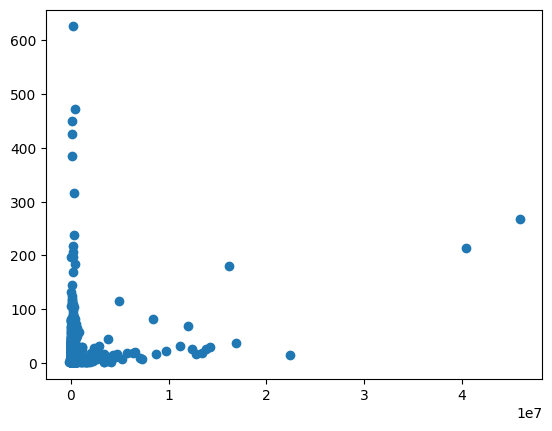

In [48]:
plt.scatter(x=df.Sales, y=df.Bills)

# Outlier detection

In [49]:
from sklearn.ensemble import IsolationForest

df2 = df.copy()
df2 = df2.drop(["Code", "Year"], axis=1)

In [50]:
model = IsolationForest()
model.fit(df2)

scores = model.decision_function(df2)
anomaly = model.predict(df2)

df2['scores'] = scores
df2['anomaly'] = anomaly

anomaly_index = list(df2.loc[df2['anomaly']==-1].index)
outliers = len(anomaly_index)
total = len(df2.index)
print(
    f"Outliers are {outliers:,} of {total:,} ({outliers / total:.1%})."
)

Outliers are 959 of 9,702 (9.9%).


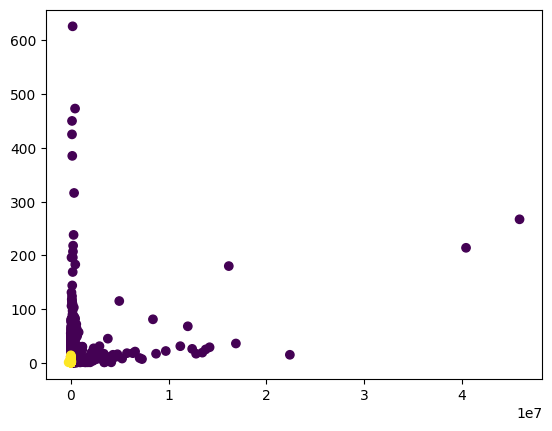

In [51]:
df2
plt.scatter(x=df2.Sales, y=df2.Bills, c=df2.anomaly)

In [52]:
df2 = df2.drop(anomaly_index, axis=0).reset_index(drop=True)

(array([5521.,    0.,    0.,    0.,    0.,    0.,    0., 1107.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  604.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  367.,    0.,    0.,    0.,
           0.,    0.,    0.,  250.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  189.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,  131.,    0.,    0.,    0.,    0.,    0.,    0.,   99.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   81.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,   50.,    0.,    0.,
           0.,    0.,    0.,    0.,   66.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,  141.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,   89.,    0.,    0.,    0.,    0.,    0.,    0.,
          48.]),
 array([ 1.  ,  1.13,  1.26,  1.39,  1.52,  1.65,  1.78,  1.91,  2.04,
         2.17,  2.3 ,  2.43,  2.56,  2.69,  2.82,  2.95,  3.08,  3.21,
         3.34,  3.47,  3.6 ,  3.73,  3.86,  3.99,  4.12,  4.

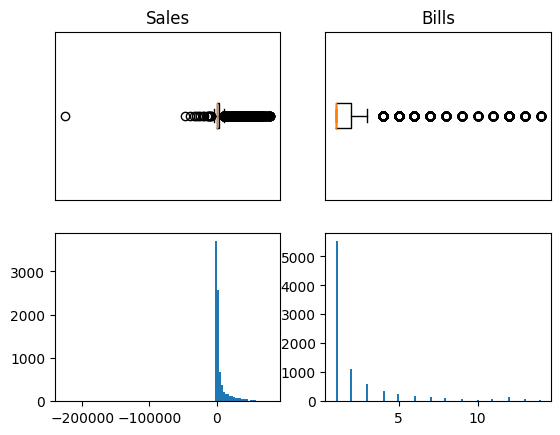

In [53]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].boxplot(x=df2.Sales, vert=False, labels=[""])
axes[0, 0].set(title="Sales", xticklabels="", xticks=[], yticks=[])
axes[0, 1].boxplot(x=df2.Bills, vert=False, labels=[""])
axes[0, 1].set(title="Bills", xticklabels="", xticks=[], yticks=[])
axes[1, 0].hist(x=df2.Sales, bins=100)
axes[1, 1].hist(x=df2.Bills, bins=100)

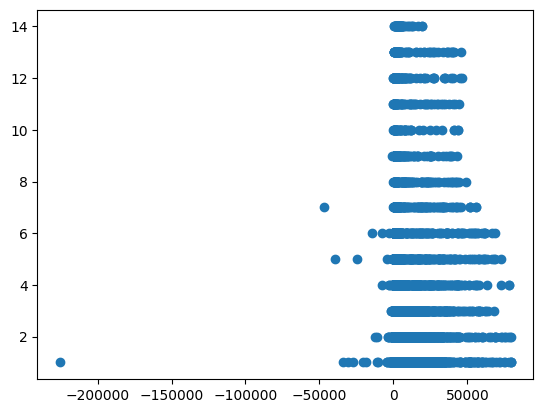

In [54]:
plt.scatter(x=df2.Sales, y=df2.Bills)

In [55]:
df2.drop(['scores', 'anomaly'], axis=1, inplace=True)

# Scaling data

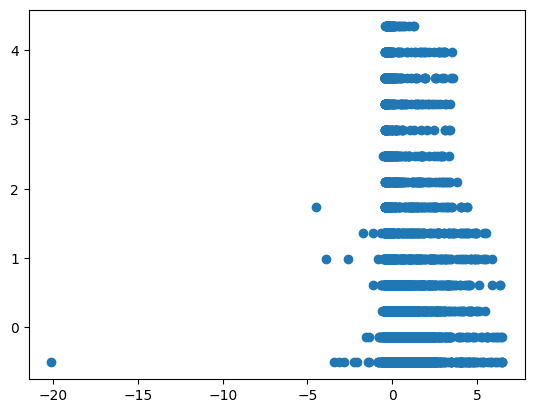

In [56]:
from sklearn.preprocessing import StandardScaler
df3 = pd.DataFrame(StandardScaler().fit_transform(df2), columns=['Sales', 'Bills'])
plt.scatter(x=df3.Sales, y=df3.Bills)

In [57]:
# Determining The Optimal Number of clusters